Code adapted from:
https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata

and

https://github.com/conradkun/PonderNet_MNIST

In [1]:
#!pip install torchsummary

!python --version


Python 3.9.13


# Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import imageio

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from IPython.display import clear_output

from lib.CAModel import CAModel
from lib.PonderCAModel import PonderCAModel
from lib.AdaptiveFireRateCAModel import AdaptiveFireRateCAModel
from lib.EnergyCAModel import EnergyCAModel

from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks
from lib.utils import *
from lib.losses import ReconstructionLoss, RegularizationLoss, ReconstructionLoss_AdaptFireRate, RegularizationLoss_AdaptFireRate

# Params

In [2]:
!nvidia-smi

Thu Nov 24 14:22:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 20%   36C    P2    52W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:09:00.0 Off |                  N/A |
| 28%   

In [3]:
# choose a GPU that's not being used
device = torch.device('cuda:0')
print("Currently using ",torch.cuda.get_device_name())

Currently using  NVIDIA GeForce GTX 1080 Ti


/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU4 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


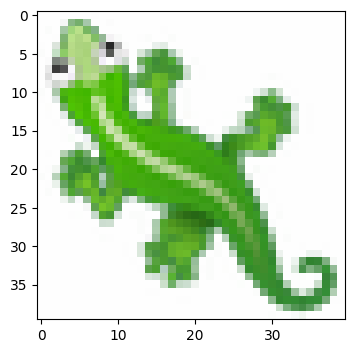

In [4]:
torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

lr = 2e-3
lr_gamma = 0.9999 ###currently not used
betas = (0.5, 0.5)
n_epoch = 8000

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 0 #@param "🦎"
EMOJI_NAME = "Lizard"
EXPERIMENT_TYPE = "Growing"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


## PonderNet and AdaptiveFireRateCA Params ##
IMG_SIZE = 72       # final padded image side length
LAMBDA_P = 1/3      # reasonable 1/expected_steps (interpretation for PonderCA)
                     
MAX_STEPS = 100
BETA = 0.01         # regularization param

## EnergyCA Params ##
BETA_ENERGY = 1e-7
MIN_FIRERATE = 0.05
MAX_FIRERATE = 0.8
CONST_FIRERATE = 0.5 # if DECAY_TYPE = 'None'
DECAY_TYPE = 'Exponential' # ['Linear', 'Exponential' or 'None']


target_img = load_emoji(TARGET_EMOJI)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.show()


# EnergyCAModel

## Initialize Training

In [6]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

ca = EnergyCAModel(CHANNEL_N, 
                   device, 
                   ).to(device)

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scaler = torch.cuda.amp.GradScaler()

###model_path = cwd+f"models/AdaptFireRatePonder_{EXPERIMENT_TYPE}_{EMOJI_NAME}_lambdapinv{1/LAMBDA_P:.0f}_maxsteps{MAX_STEPS}_beta{BETA:.0e}"
model_path = f"models/new/EnergyCA_{DECAY_TYPE}DecayFixedSteps_minFireRate{MIN_FIRERATE:.0e}_maxFireRate{MAX_FIRERATE:.0e}_betaEnergy{BETA_ENERGY:.0e}"
debug('BETA_ENERGY', 'MIN_FIRERATE', 'MAX_FIRERATE', same_line=True)
debug("model_path")

BETA_ENERGY = 1e-07; MIN_FIRERATE = 0.05; MAX_FIRERATE = 0.8; 

model_path = 'models/new/EnergyCA_ExponentialDecayFixedSteps_minFireRate5e-02_maxFireRate8e-01_betaEnergy1e-02'


## Train Loop

batch (before/after):


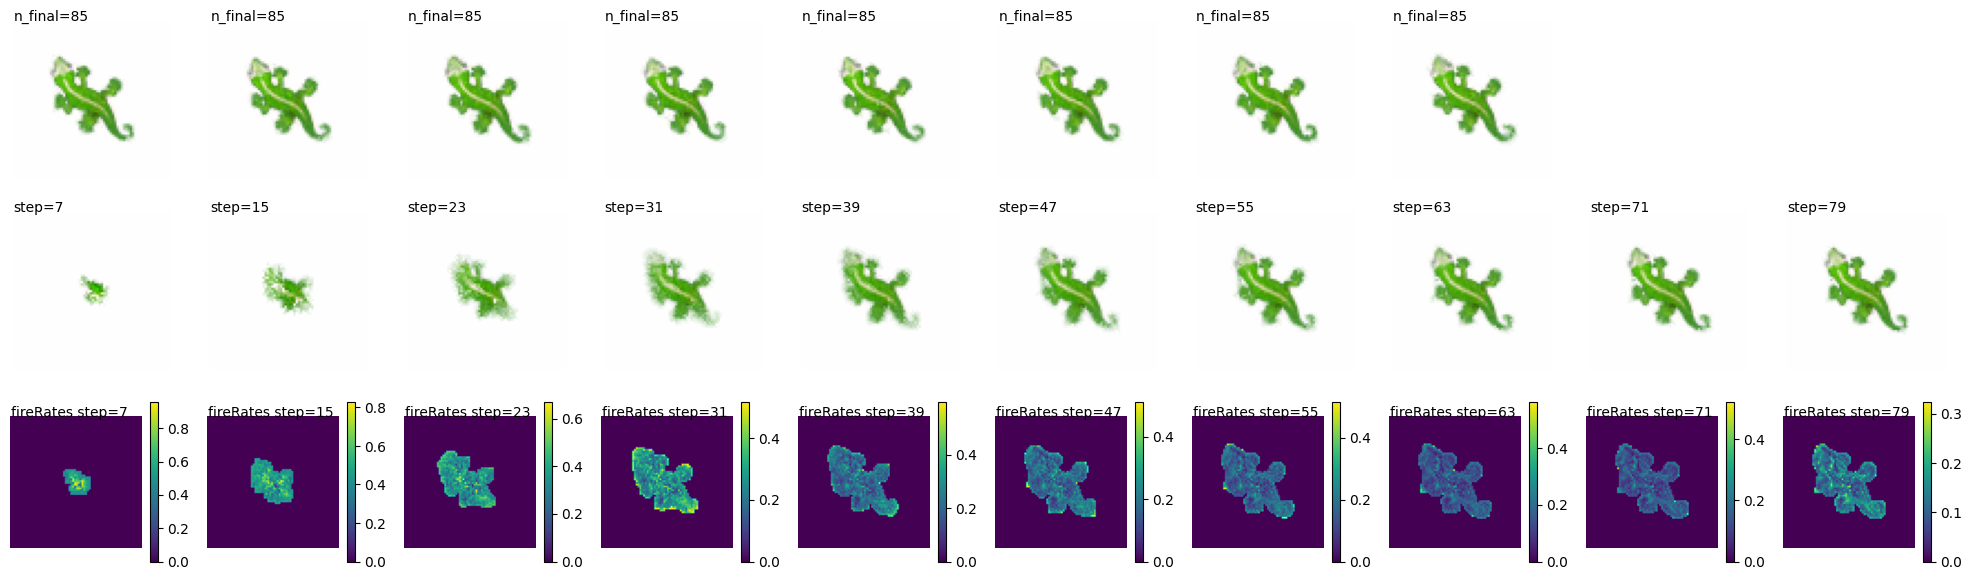

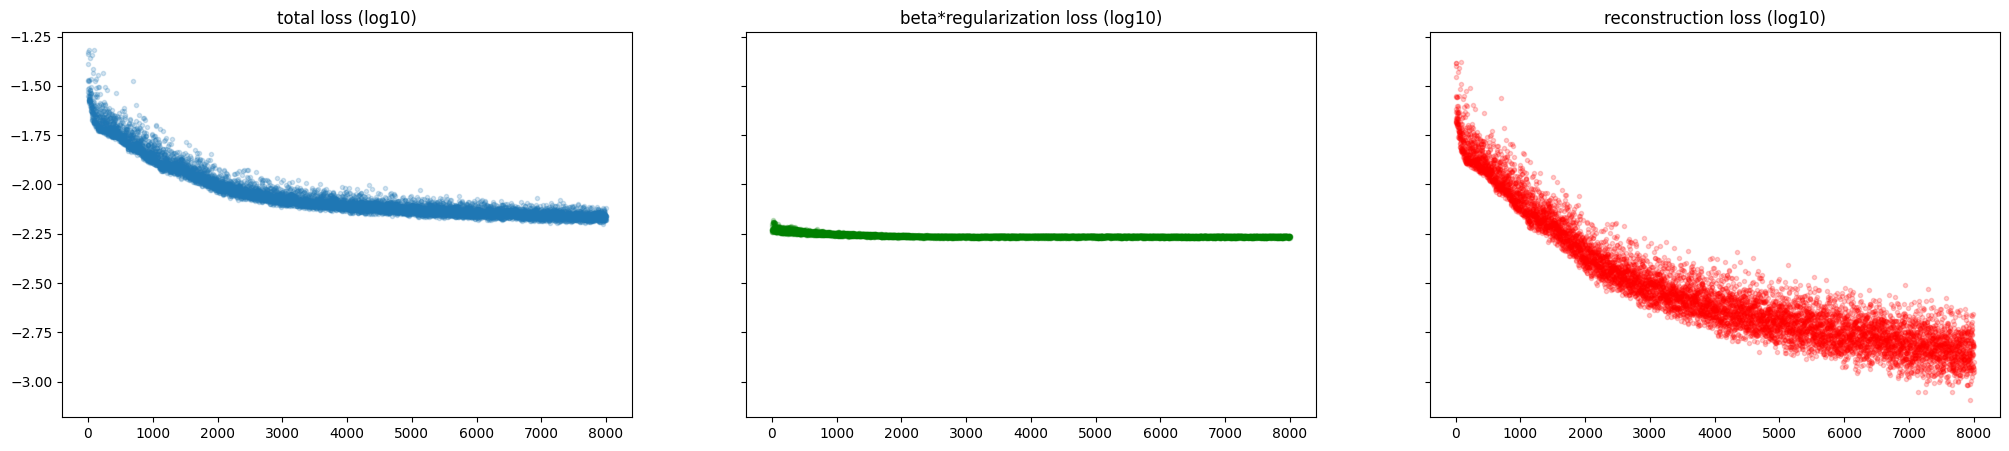

100%|██████████| 8001/8001 [39:10<00:00,  3.40it/s]


In [7]:
# create decreasing fireRates from MIN->MAX_FIRERATE (right now with fixed steps)
if DECAY_TYPE == 'Exponential':
    decay_map = torch.from_numpy(np.exp(np.linspace(np.log(MAX_FIRERATE),np.log(MIN_FIRERATE), 96)))
elif DECAY_TYPE == 'Linear':
    decay_map = torch.from_numpy(np.linspace(MAX_FIRERATE, MIN_FIRERATE, 96))
elif DECAY_TYPE == 'None':
    decay_map = torch.ones(96) * CONST_FIRERATE

def train(x, target, steps, optimizer, scaler, decay_map, scheduler=None):
    optimizer.zero_grad(set_to_none=True)

    #with torch.cuda.amp.autocast(): #with autocast, the dx's become nan for some reason
    x_steps, fireRates_steps = ca(x, steps=steps)
    x_final = x_steps[-1,:,:,:,:4]
    decay_map = decay_map[0:steps]
    
    # compute the loss on the live cells
    goal_fireRate_tensor = torch.einsum("i,ijkl -> ijkl", decay_map, torch.ones(steps, BATCH_SIZE, IMG_SIZE, IMG_SIZE)).to(device)

    # loss computation
    loss_rec_val = F.mse_loss(x_final, target)
    loss_energy_val = BETA_ENERGY * torch.mean(torch.square(fireRates_steps[:,:,:,:,0]-goal_fireRate_tensor).sum(dim=[0,2,3]))
    loss = loss_rec_val + loss_energy_val

    del goal_fireRate_tensor###

    if 0:
          debug(
              "life_mask_steps.shape",
          )
          
    # Using gradient scaling bc of float16 precision (not needed if autocast is off)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    #scheduler.step()

    return x_steps, loss, loss_rec_val, loss_energy_val, fireRates_steps

loss_log = []
loss_energy_log = []
loss_rec_log = []

# Train loop
for i in tqdm(range(n_epoch+1)):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x_steps, loss, loss_rec_val, loss_energy_val, fireRates_steps = train(x0, pad_target, np.random.randint(64,96), optimizer, scaler, decay_map)

    step_i = len(loss_log)
    loss_log.append(loss.item())
    loss_rec_log.append(loss_rec_val.item())
    loss_energy_log.append(loss_energy_val.item())
    
    if step_i%100 == 0:
        clear_output()
        visualize_batch_energy(
            x0.detach().cpu().numpy(), 
            x_steps.detach().cpu().numpy(), 
            fireRates_steps.detach().cpu().numpy().astype(np.float32), 
            progress_steps=10)
        plot_loss_reg_rec(loss_log, loss_energy_log, loss_rec_log)
    if step_i%2000 == 0 and step_i>0:
      torch.save(ca.state_dict(), model_path+f"_epoch{step_i}.pth")

target_mask.shape = torch.Size([1, 1, 72, 72, 4])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

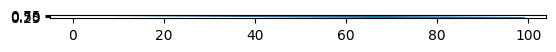

In [40]:
# what the fireRate of a cell should be, throughout time
#decay_map = torch.from_numpy(np.exp(np.linspace(np.log(0.5),np.log(0.1), 100)))
# mask in the shape of pad_target, with 1's where the target is

min_fireRatestest = torch.einsum("i,ijkl -> ijkl", decay_map, torch.ones(100, BATCH_SIZE, IMG_SIZE, IMG_SIZE))
plt.plot(min_fireRatestest.numpy()[:,0,36,36])
plt.imshow(target_mask[0,:,:,0])
#animate_steps(min_fireRatestest.detach().cpu(), colorbar_plots=[0])

## Load previous trained

In [8]:
n = 8000
max_steps = MAX_STEPS*10
test_ca = EnergyCAModel(CHANNEL_N, 
                   device, 
                   ).to(device)
                   
test_model_path = "models/new/EnergyCA_ExponentialDecayFixedSteps_minFireRate5e-02_maxFireRate8e-01_betaEnergy1e-02" + f"_epoch{n}.pth"
#test_model_path = model_path + f"_epoch{n}.pth"

test_ca.load_state_dict(torch.load(model_path_full, map_location=device))

<All keys matched successfully>

## See NCA through time

x_steps.shape = torch.Size([1000, 1, 72, 72, 16])
fireRates_steps.shape = torch.Size([1000, 1, 72, 72, 1])


/tmp/ipykernel_331773/3410085283.py:19: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  [F.mse_loss(x_steps[k,i,:,:,:4], pad_target).cpu() for k in range(max_steps)]


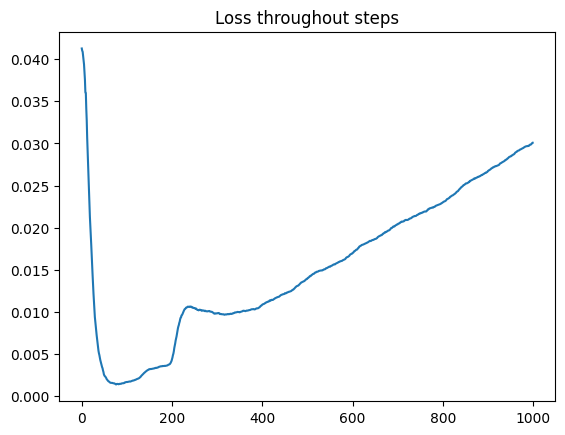

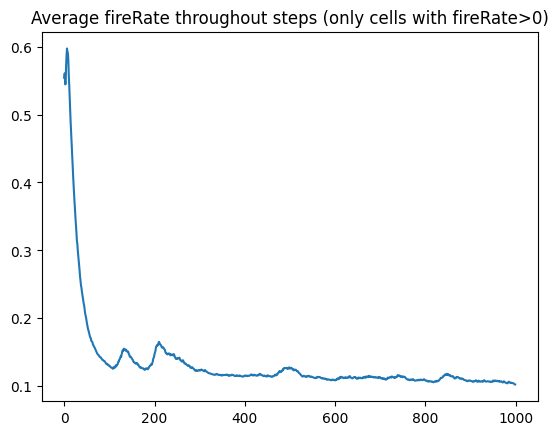

In [9]:
import time
from IPython import display

# create seeds
batch_size=1
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(batch_size)
x0 = batch.x 
x = torch.tensor(x0).to(device)

# run inference
with torch.no_grad():
  x_steps, fireRates_steps = test_ca(x, max_steps, damage_at_step=-1, damage_location='head', damaged_in_batch=1)

debug("x_steps.shape")
debug("fireRates_steps.shape")
# losses throughout time
losses = [
     [F.mse_loss(x_steps[k,i,:,:,:4], pad_target).cpu() for k in range(max_steps)] 
    for i in range(batch_size)]

# average fireRate of cells throughout time, but only counting fireRates bigger than 0
avg_fireRates = [
    [torch.mean(fireRates_steps[k,i,:,:,:][fireRates_steps[k,i,:,:,:]>0]).cpu() for k in range(max_steps)]
    for i in range(batch_size)]
    

for i in range(batch_size):
  plt.title("Loss throughout steps")
  plt.plot(losses[i])
  plt.show()
  plt.title("Average fireRate throughout steps (only cells with fireRate>0)")
  plt.plot(avg_fireRates[i])
  plt.show()


In [10]:
animate_steps(
    to_rgb(x_steps.detach().cpu()),
    fireRates_steps.detach().cpu(),
    colorbar_plots=[1] 
    )


## Compare EnergyCAModel to CAModel

In [ ]:
# load EnergyCA model at epoch 8000
n = 8000
max_steps = MAX_STEPS*4
energy_ca = EnergyCAModel(CHANNEL_N,
                     device,
                        ).to(device)

test_model_path = "models/EnergyCA_biasFals_perceptionInput_Growing_Lizard_minFireRate2e-01_maxFireRate8e-01_betaEnergy1e-02" 
model_path_full = test_model_path + f"_epoch{n}.pth"
energy_ca.load_state_dict(torch.load(model_path_full, map_location=device))

In [ ]:
# load CA model at epoch 8000
def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])

noponder_ca = CAModel(CHANNEL_N, 
                   CELL_FIRE_RATE, 
                   device,
                   ).to(device)
test_model_path = f"models/new/NoPonder_Growing_Lizard"
model_path_full = test_model_path + f"_epoch{n}.pth"
noponder_ca.load_state_dict(torch.load(model_path_full, map_location=device))

In [ ]:
# run energy_ca for max_steps
with torch.no_grad():
    x_steps, fireRates_steps = energy_ca(x, max_steps)
    
# for noponder_ca, we need to run it for 1 step at a time
x_steps_noponder = torch.zeros((max_steps, batch_size, 72, 72, CHANNEL_N))
x_steps_noponder[0] = x
for i in range(max_steps-1):
    x_steps_noponder[i+1]= noponder_ca(x_steps_noponder[i])


# AdaptiveFireRateCAModel

## Initialize Training

In [21]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

ca = AdaptiveFireRateCAModel(CHANNEL_N, 
                   device, 
                   img_size=IMG_SIZE, 
                   max_steps=MAX_STEPS,
                   lambda_eps=1e-1
                   ).to(device)

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scaler = torch.cuda.amp.GradScaler()

def cellwise_loss(x, target):
    ''' returns mean cellwise loss across rgb channels 
        Output shape: (batch_size, img_size, img_size)'''
    return torch.mean(torch.pow(x[..., :4]-target, 2), dim=-1)

loss_rec = ReconstructionLoss_AdaptFireRate(cellwise_loss)
loss_reg = RegularizationLoss_AdaptFireRate(lambda_p=LAMBDA_P, max_steps=MAX_STEPS, device=device)

model_path = f"models/new/AdaptFireRatePonder_{EXPERIMENT_TYPE}_{EMOJI_NAME}_lambdapinv{1/LAMBDA_P:.0f}_maxsteps{MAX_STEPS}_beta{BETA:.0e}"

debug('1/LAMBDA_P', 'MAX_STEPS', 'BETA', same_line=True)

1/LAMBDA_P = 3.3333333333333335; MAX_STEPS = 100; BETA = 0.01; 



## Train Loop

batch (before/after):


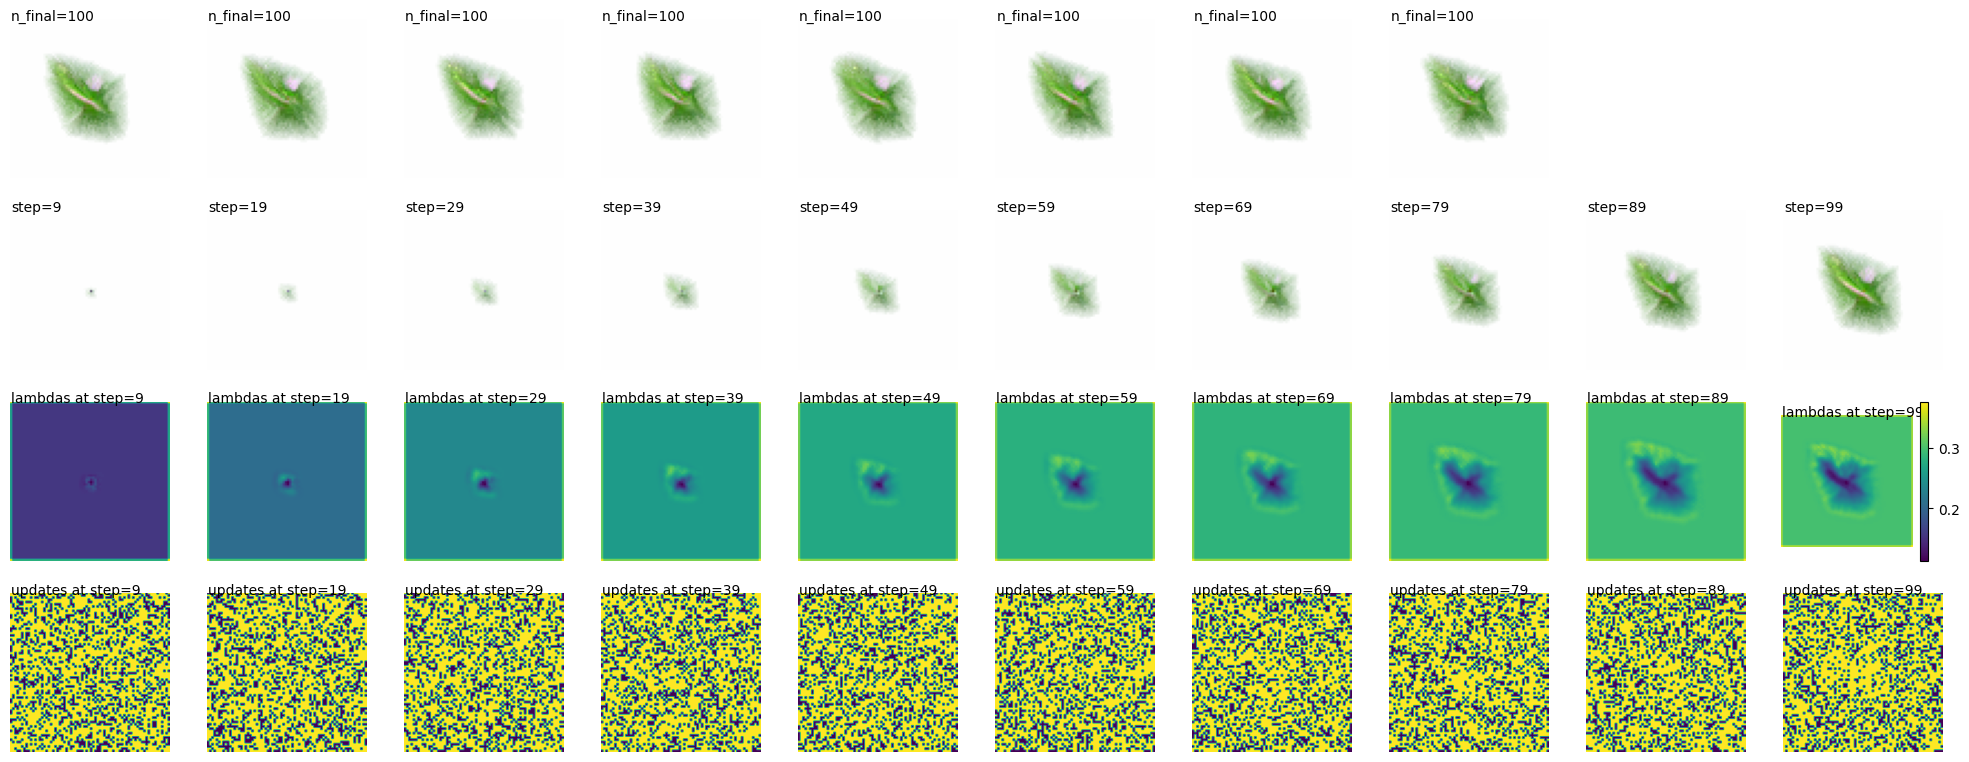

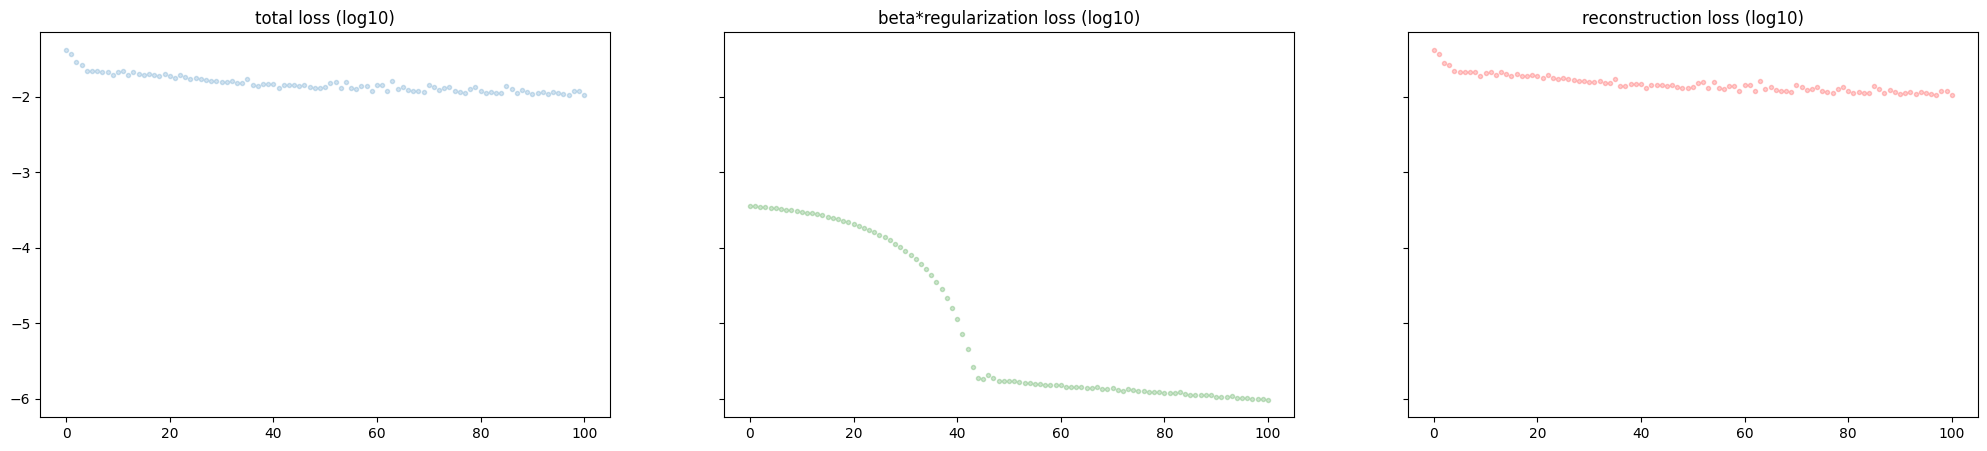

  2%|▏         | 122/8001 [01:08<1:14:15,  1.77it/s]


KeyboardInterrupt: 

In [22]:
#@title Train loop

def train(x, target, optimizer, scaler, scheduler=None):
    optimizer.zero_grad(set_to_none=True)

    with torch.cuda.amp.autocast():
        x_steps, p_steps, lambdas_steps, update_grid_steps = ca(x)
        loss_rec_val = torch.mean(loss_rec(p_steps, x_steps, pad_target)) #mean across batch
        loss_reg_val = BETA*torch.mean(loss_reg(p_steps))
        if 0:
          debug(
              #"loss_rec_val.shape",
              #"loss_reg_val.shape",
              #"loss_rec_val.item()",
              #"loss_reg_val.item()",
              "float(lambdas_steps.min())",
              "float(lambdas_steps.max())",
              #"torch.sum(p_steps, 0)"
          )
        loss_val = loss_rec_val + loss_reg_val

    # Using gradient scaling bc of float16 precision
    scaler.scale(loss_val).backward()
    scaler.step(optimizer)
    scaler.update()
    
    #print("\n"); print("n_steps",n_steps.detach().cpu().numpy()); print("loss_val", loss_val.item());print("lambda_steps[-1]", lambda_steps[-1].detach().cpu().numpy())
    # return only last step before halting
    return x_steps, loss_val, loss_rec_val, loss_reg_val, lambdas_steps , update_grid_steps, p_steps


loss_log = []
loss_reg_log = []
loss_rec_log = []
for i in tqdm(range(n_epoch+1)):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss, loss_rec_val, loss_reg_val, lambdas_steps, update_grid_steps, p_steps = train(x0, pad_target, optimizer, scaler)

    step_i = len(loss_log)
    loss_log.append(loss.item())
    loss_rec_log.append(loss_rec_val.item())
    loss_reg_log.append(loss_reg_val.item())
    
    if step_i%50 == 0:
        clear_output()
        visualize_batch_adapt(
            x0.detach().cpu().numpy(), 
            x.detach().cpu().numpy(), 
            lambdas_steps.detach().cpu().numpy().astype(np.float32), 
            update_grid_steps.detach().cpu().numpy().astype(np.float32),
            progress_steps=10)
        plot_loss_reg_rec(loss_log, loss_reg_log, loss_rec_log)
    if step_i%1000 == 0 and step_i>0:
      torch.save(ca.state_dict(), model_path+f"_epoch{step_i}.pth")

In [ ]:
torch.cuda.empty_cache()

perc_vec.shape = torch.Size([1, 48, 72, 72])
x.shape = torch.Size([1, 72, 72, 16])


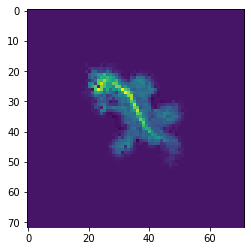

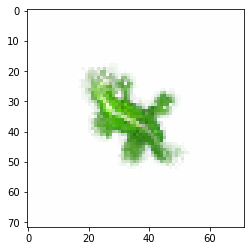

In [48]:
debug("perc_vec.shape")
debug("x.shape")
plt.imshow(perc_vec.cpu().detach()[0,0]); plt.show()
plt.imshow(to_rgb(x[0].detach().cpu()))

## Playing with Model

## Load previous trained

In [22]:
n = 4000
max_steps = MAX_STEPS*2
test_ca = AdaptiveFireRateCAModel(CHANNEL_N, 
                   device, 
                   img_size=IMG_SIZE, 
                   max_steps=max_steps
                   ).to(device)
test_lambda_p = 1/32
test_beta = 0.01
#test_model_path = cwd+f"models/AdaptFireRatePonder_{EXPERIMENT_TYPE}_{EMOJI_NAME}_lambdapinv{1/test_lambda_p:.0f}_maxsteps{MAX_STEPS}_beta{test_beta:.0e}"
test_model_path = cwd + "models/test"
model_path_full = test_model_path + f"_epoch{n}.pth"
test_ca.load_state_dict(torch.load(model_path_full, map_location=device))

<All keys matched successfully>

## See NCA through time

x_steps.shape = torch.Size([200, 1, 72, 72, 16])


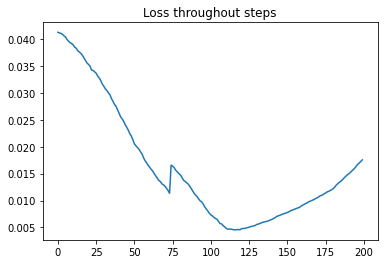

In [23]:
import time
from IPython import display

pause_time = 0.1 #seconds

# create seeds
batch_size=1
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(batch_size)
x0 = batch.x 
x = torch.tensor(x0).to(device)

# run inference
with torch.no_grad():
  x_steps, p_steps, lambdas_steps, update_grid_steps = test_ca(x, damage_at_step=75, damage_location='head')

debug("x_steps.shape")
losses = [
     [np.mean(cellwise_loss(x_steps.detach().cpu()[k,i], pad_target.cpu())[0].cpu().numpy()) for k in range(max_steps)] 
    for i in range(batch_size)]

for i in range(batch_size):
  plt.title("Loss throughout steps")
  plt.plot(losses[i])

In [24]:
animate_steps(
    to_rgb(x_steps.detach().cpu()),
    1-lambdas_steps.detach().cpu(),
    colorbar_plots=[1] 
    )


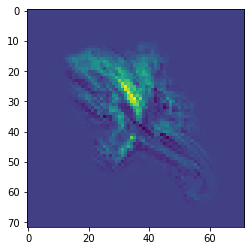

In [90]:
plt.imshow(lambdas_steps.detach().cpu()[150,0])

# PonderCAModel

## Initialize Training

In [4]:
#@title Initialize Training
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

ca = PonderCAModel(CHANNEL_N, 
                   CELL_FIRE_RATE, 
                   device, 
                   img_size=IMG_SIZE, 
                   max_steps=MAX_STEPS
                   ).to(device)

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scaler = torch.cuda.amp.GradScaler()

def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])

loss_rec = ReconstructionLoss(loss_f)
loss_reg = RegularizationLoss(LAMBDA_P, max_steps=MAX_STEPS, device=device)
model_path = cwd+f"models/Ponder_{EXPERIMENT_TYPE}_{EMOJI_NAME}_lambdapinv{1/LAMBDA_P:.0f}_maxsteps{MAX_STEPS}_beta{BETA:.0e}"


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [ ]:
from torchsummary import summary
#summary(ca, input_size=(IMG_SIZE, IMG_SIZE, CHANNEL_N))


In [ ]:
#@title Train loop

def train(x, target, optimizer, scaler, scheduler=None):
    optimizer.zero_grad(set_to_none=True)

    with torch.cuda.amp.autocast():
        x_steps, p_steps, lambda_steps, n_steps = ca(x)
        loss_rec_val = loss_rec(p_steps, x_steps, pad_target)
        loss_reg_val = BETA*loss_reg(p_steps)
        if 1:###debug
          print("loss_rec_val.shape", loss_rec_val.shape)
          print("\nloss_rec_val", loss_rec_val.item(), "loss_reg_val", loss_reg_val.item())
          print("lambda_steps.min()", float(lambda_steps.min()))
          print("lambda_steps.max()", float(lambda_steps.max()))
          print("p_steps.sum()", torch.sum(p_steps, 0))
        loss_val = loss_rec_val + loss_reg_val

    # Using gradient scaling bc of float16 precision
    scaler.scale(loss_val).backward()
    scaler.step(optimizer)
    scaler.update()
    ###scheduler.step()
    
    #print("\n"); print("n_steps",n_steps.detach().cpu().numpy()); print("loss_val", loss_val.item());print("lambda_steps[-1]", lambda_steps[-1].detach().cpu().numpy())
    # return only last step before halting
    return x_steps, loss_val, loss_rec_val, loss_reg_val, n_steps, p_steps, lambda_steps


loss_log = []
loss_reg_log = []
loss_rec_log = []
avg_steps_log = []
for i in tqdm(range(n_epoch+1)):
    if USE_PATTERN_POOL: #for regen or persist
        batch = pool.sample(BATCH_SIZE)
        x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        x0 = batch.x[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss, loss_rec_val, loss_reg_val, n_steps, p_steps, lambda_steps = train(x0, pad_target, optimizer, scaler)

    if USE_PATTERN_POOL: #for regen or persist
        batch.x[:] = x.detach().cpu().numpy()
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())
    loss_rec_log.append(loss_rec_val.item())
    loss_reg_log.append(loss_reg_val.item())
    avg_steps_log.append(n_steps.mean(dtype=float).item())
    
    if step_i%50 == 0:
        #clear_output()
        visualize_batch_ponder(x0.detach().cpu().numpy(), x.detach().cpu().numpy(), n_steps.detach().cpu().numpy())
        plot_loss_reg_rec(loss_log, loss_reg_log, loss_rec_log)
        plot_avg_steps(avg_steps_log)
    if step_i%1000 == 0:
      torch.save(ca.state_dict(), model_path+f"_epoch{step_i}.pth")

## Debugging

In [ ]:
p_steps_new = p_steps.transpose(0,1).detach().cpu().numpy()[1]
p_g_new = p_g.detach().cpu().numpy()[0]
lambda_steps_new = lambda_steps.transpose(0,1).detach().cpu().numpy()[1]
plt.plot(lambda_steps_new)
#plt.plot(p_g_new)

center = array([[[[-0.08]]],


       [[[-0.35]]]])
mask.shape = (1, 72, 72)


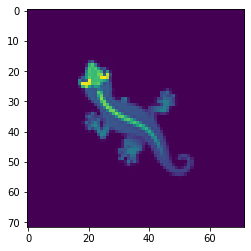

In [ ]:
# finding mask locations for lizard parts
def make_circle_masks(n, h, w, location='random'):
    x = np.linspace(-1.0, 1.0, w)[None, None, :]
    y = np.linspace(-1.0, 1.0, h)[None, :, None]
    if location=='random':
        center = np.random.random([2,n,1,1])*1.0-0.5
        r = np.random.random([n, 1, 1])*0.3+0.1
    elif location=='head':
        center = np.ones([2,n,1,1])*(-0.35)
        r = np.ones([n, 1, 1])*0.1 + 0.1
    elif location=='leg1':
        center = np.ones([2,n,1,1])
        center[0] = -0.08; center[1] = -0.35
        r = np.ones([n, 1, 1])*0.05 + 0.1  
    debug("center")  
    x, y = (x-center[0])/r, (y-center[1])/r
    mask = (x*x+y*y < 1.0).astype(np.float32)
    return mask

mask = make_circle_masks(1, 72, 72, location='leg1')
debug("mask.shape")
plt.imshow(pad_target.cpu()[0,:,:,0]*(1-mask[0]))


In [ ]:
class RegularizationLoss(nn.Module):
    '''
        Computes the KL-divergence between the halting distribution generated
        by the network and a geometric distribution with parameter `lambda_p`.
        Parameters
        ----------
        lambda_p : float
            Parameter determining our prior geometric distribution.
        max_steps : int
            Maximum number of allowed pondering steps.
    '''

    def __init__(self, lambda_p: float, max_steps: int = 1_000, device=None):
        super().__init__()

        p_g = torch.zeros((max_steps,), device=device)
        not_halted = 1.
        for k in range(max_steps):
            p_g[k] = not_halted * lambda_p
            not_halted = not_halted * (1 - lambda_p)
        self.p_g = nn.Parameter(p_g, requires_grad=False)
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, p: torch.Tensor):
        '''
            Compute the loss.
            Parameters
            ----------
            p : torch.Tensor
                Probability of halting at each step, representing our
                halting distribution.
            Returns
            -------
            loss : torch.Tensor
                Scalar representing the regularization loss.
        '''
        p = p.transpose(0, 1)
        p_g = self.p_g[None, :p.shape[1]].expand_as(p)
        return self.kl_div(p.log(), p_g), p_g

losses= []

# try avg_steps = 63, 64 and 65
lambda_p_g = 1/64
max_steps = 100
for lambda_steps in range(64,66):
  lambda_p = 1/lambda_steps*torch.ones((1,))
  un_halted_prob = torch.ones((1,))
  p = []
  for i in range(max_steps):
    p.append(un_halted_prob * lambda_p)
    un_halted_prob = un_halted_prob * (1 - lambda_p)

  loss_reg = RegularizationLoss(lambda_p_g, max_steps=max_steps, device=device)



  p = torch.stack(p).to(device)
  loss, p_g = loss_reg(p)
  losses.append(loss.item())

plt.plot(losses)
print(np.argmin(losses))
print(np.min(losses))

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


tensor([5.1953e-01, 2.4963e-01, 1.1994e-01, 5.7618e-02, 2.7680e-02, 1.3307e-02,
        6.3906e-03, 3.0718e-03, 1.4754e-03, 7.0958e-04, 3.4146e-04, 1.6456e-04,
        7.9559e-05, 3.8730e-05, 1.9120e-05, 9.7023e-06, 5.1723e-06, 3.0266e-06,
        1.9537e-06, 1.4768e-06, 1.2384e-06, 1.1192e-06, 1.0596e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-

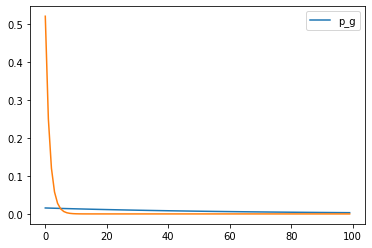

In [ ]:
#lambda_p = 1/64*torch.ones((1,))
lambda_p_g = 1/64*torch.ones((1,))
#un_halted_prob_p = torch.ones((1,))
un_halted_prob_p_g = torch.ones((1,))

p = []
p_g = []
max_steps = 100
for i in range(max_steps):
  #p.append(un_halted_prob_p * lambda_p)
  #un_halted_prob_p = un_halted_prob_p * (1 - lambda_p)

  p_g.append(un_halted_prob_p_g * lambda_p_g)
  un_halted_prob_p_g = un_halted_prob_p_g * (1 - lambda_p_g)

plt.plot(p_g, label='p_g')
#plt.plot(p, label='p')
plt.legend()

p = torch.tensor(p_test[0]) + 1e-6#torch.stack(p).transpose(0,1)
plt.plot(p, label='p')

p_g = torch.stack(p_g).transpose(0,1)
kl_div = torch.nn.KLDivLoss(reduction='batchmean')(p.log(), p_g)
print(p, p_g, kl_div.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([8, 72, 72])
torch.Size([8, 72, 72]) tensor(0.4884) torch.int32


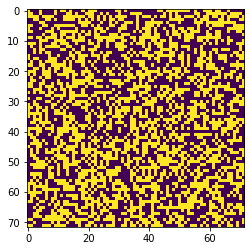

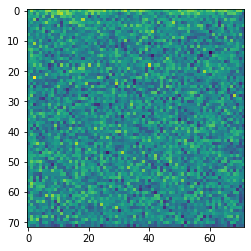

(array([   3.,   70.,  360.,  965., 1546., 1278.,  718.,  197.,   45.,
           2.]),
 array([0.44494548, 0.45946002, 0.47397456, 0.4884891 , 0.50300366,
        0.51751816, 0.5320327 , 0.54654723, 0.5610618 , 0.5755763 ,
        0.5900909 ], dtype=float32),
 <a list of 10 Patch objects>)

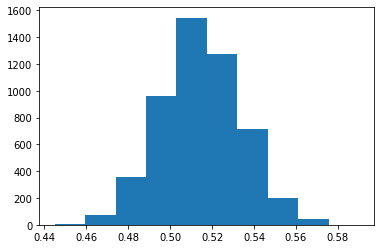

In [ ]:
# for AdaptiveFireRateCAModel
import torch.nn.functional as F
eps=1e-6
x = torch.rand((8,72,72,16))
un_halted_prob = x.new_ones((8,72,72))
conv1 = nn.Conv2d(16, 20, kernel_size=3, padding='same')
conv2 = nn.Conv2d(20, 1, kernel_size=3, padding='same')

lambdas = F.sigmoid(conv2(F.relu(conv1(x.transpose(1,3))))).squeeze(dim=1)
bernoulli = 1-torch.bernoulli(lambdas).to(torch.int)
p_n = un_halted_prob * lambdas + eps

print(p_n.shape)
print(bernoulli.shape, torch.count_nonzero(bernoulli[0])/(72**2), bernoulli.dtype)
plt.imshow(bernoulli[0]); plt.show()
plt.imshow(lambdas[0].detach().cpu().numpy()); plt.show()
plt.hist(lambdas[0].detach().cpu().numpy().flatten())

loss shape torch.Size([8])


TypeError: Invalid shape () for image data

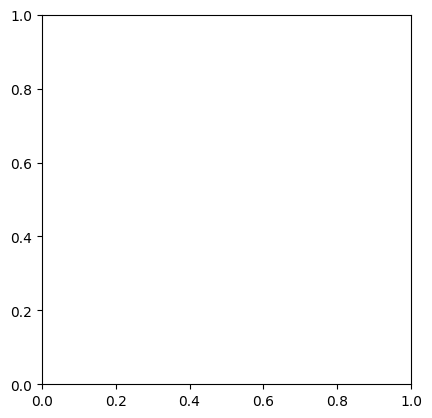

In [8]:
# testing regul loss before .mean
lambda_p_g = 0.05
max_steps = 100
x = torch.rand((8,72,72,16))
lambdas = x.new_ones((8,72,72))*0.05
lambdas[0,36,36] = 0.04
lambdas[0,20,20] = 0.02

un_halted_prob = x.new_ones((8,72,72))
p = []
for i in range(max_steps):
  p.append(un_halted_prob * lambdas)
  un_halted_prob = un_halted_prob * (1 - lambdas)

loss_reg = RegularizationLoss_AdaptFireRate(lambda_p_g, max_steps=max_steps, device='cpu')

p = torch.stack(p)
loss = loss_reg(p)
print("loss shape", loss.shape)
plt.imshow(loss[0])
plt.colorbar()

## Playing with Model

In [5]:
#@title Load previously trained
n = 4000
max_steps_model = 100
max_steps = max_steps_model*2
test_ca = PonderCAModel(CHANNEL_N, 
                   CELL_FIRE_RATE, 
                   device, 
                   img_size=IMG_SIZE, 
                   max_steps=max_steps,
                   training=True,
                   ).to(device)
test_lambda_p = 1/64
test_beta = 0.1
test_model_path = cwd+f"models/Ponder_{EXPERIMENT_TYPE}_{EMOJI_NAME}_lambdapinv{1/test_lambda_p:.0f}_maxsteps{max_steps_model}_beta{test_beta:.0e}"
model_path_full = test_model_path + f"_epoch{n}.pth"
test_ca.load_state_dict(torch.load(model_path_full, map_location=device))

<All keys matched successfully>

x.shape torch.Size([1, 72, 72, 16])


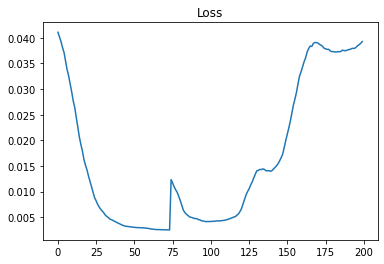

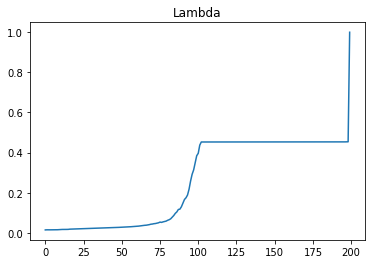

In [7]:
#@title See NCA through time
# first go to the Initialize Training cell and run it
import time
from IPython import display

pause_time = 0.1 #seconds

# create seeds
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(1)
x0 = batch.x 
x = torch.tensor(x0).to(device)
print("x.shape",x.shape)

# run inference
with torch.no_grad():
  x_steps, p_steps, lambda_steps, n_steps = test_ca(x, damage_at_step=75, damage_location = 'head')

losses = [loss_f(x_steps.detach().cpu()[i][0], pad_target.cpu()) for i in range(max_steps)]
lambdas = [lambda_steps[i].item() for i in range(max_steps)]

plt.plot(losses); plt.title("Loss"); plt.show()
plt.plot(lambdas); plt.title("Lambda"); plt.show()

In [8]:
animate_steps(
    to_rgb(x_steps.detach().cpu())
)

In [ ]:
x_cpy = torch.clone(x)
damage = 1 - make_circle_masks(1,72,72)[...,None]
x_cpy[]*=damage
print(damage.shape)
plt.subplot(1,2,1)
plt.imshow(damage[0,...,0])
plt.subplot(1,2,2)
plt.imshow(to_rgb(x_cpy))

RuntimeError: ignored

# CAModel

## Initialize Training

In [5]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)
scaler = torch.cuda.amp.GradScaler()

model_path = f"models/new/NoPonder_{EXPERIMENT_TYPE}_{EMOJI_NAME}"



## Train loop

batch (before/after):


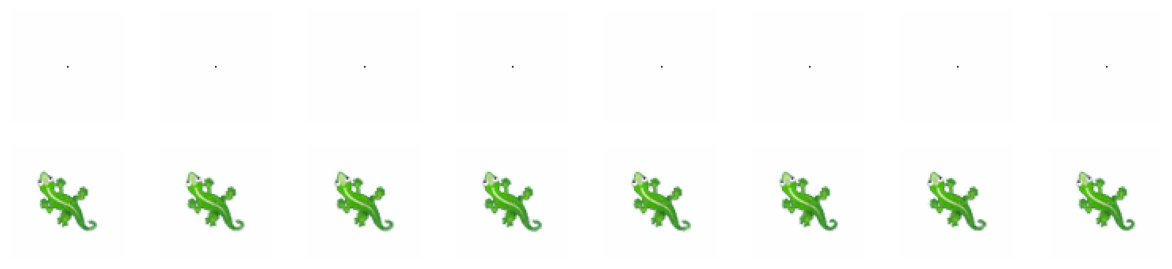

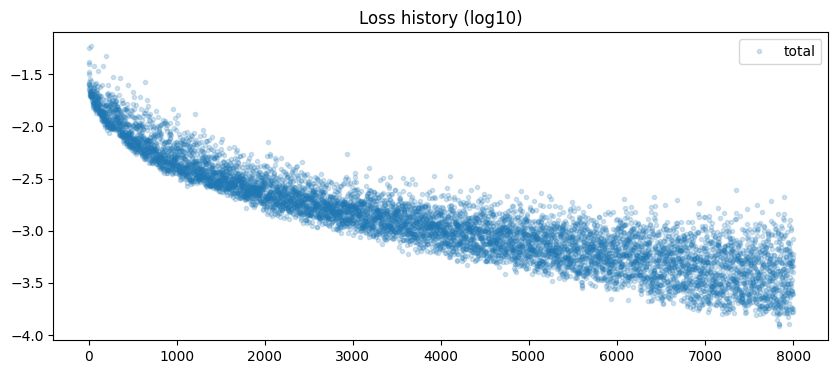

100%|██████████| 8001/8001 [51:18<00:00,  2.60it/s]


In [6]:

def train(x, target, steps, optimizer, scaler):
    optimizer.zero_grad(set_to_none=True)

    with torch.cuda.amp.autocast():
        x = ca(x, steps=steps)
        loss = F.mse_loss(x[:, :, :, :4], target)

    # Using gradient scaling bc of float16 precision
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    #scheduler.step()

    return x, loss

def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])


loss_log = []
for i in tqdm(range(n_epoch+1)):
    if USE_PATTERN_POOL: #for regen or persist
        batch = pool.sample(BATCH_SIZE)
        x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        x0 = batch.x[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss = train(x0, pad_target, np.random.randint(64,96), optimizer, scaler)

    if USE_PATTERN_POOL: #for regen or persist
        batch.x[:] = x.detach().cpu().numpy()
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())
    
    if step_i%100 == 0:
        clear_output()
        visualize_batch(x0.detach().cpu().numpy(), x.detach().cpu().numpy())
        plot_loss(loss_log)
    if step_i%8000 == 0:
      torch.save(ca.state_dict(), model_path+f"_epoch{step_i}.pth")

In [ ]:
print(x.shape)
print(pad_target.shape)
lst = [F.mse_loss(x[i, :, :, :4], pad_target[0]).item() for i in range(8)]
print(lst)

torch.Size([8, 72, 72, 16])
torch.Size([1, 72, 72, 4])
[0.0019301739521324635, 0.0018159340834245086, 0.0013518367195501924, 0.0017180693103000522, 0.001331152394413948, 0.002313807839527726, 0.0023736520670354366, 0.001498031080700457]


## Playing with Model

In [11]:
#@title Load previously trained
def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])

n = 8000
max_steps = MAX_STEPS*10
damage_at_step = MAX_STEPS
damage_location = 'head'
noponder_ca = CAModel(CHANNEL_N, 
                   CELL_FIRE_RATE, 
                   device,
                   ).to(device)
test_model_path = "models/new/NoPonder_Growing_Lizard"
model_path_full = test_model_path + f"_epoch{n}.pth"
noponder_ca.load_state_dict(torch.load(model_path_full, map_location=device))

<All keys matched successfully>

x.shape torch.Size([1, 72, 72, 16])
x_steps.shape = torch.Size([1000, 1, 72, 72, 16])


/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


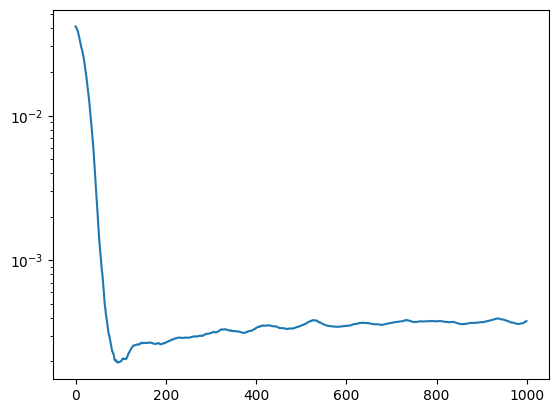

In [14]:
#@title See NCA through time {vertical-output: false}
import time
from IPython import display


# create seeds
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(1)
x0 = batch.x 
x = torch.tensor(x0).to(device)
print("x.shape",x.shape)

losses = []
x_steps = torch.zeros((max_steps, 1, IMG_SIZE, IMG_SIZE, CHANNEL_N))

for i in range(0,max_steps):
  with torch.no_grad():
    x = noponder_ca(x)
    # apply damage
    if i == damage_at_step:
      x = damage_batch(x, device, img_size = 72, damage_at_step = damage_location ,damage_location = damage_location)
  x_steps[i,0] = x
debug("x_steps.shape")
losses = [loss_f(x_steps[i,0], pad_target.cpu()).detach().cpu() for i in range(max_steps)]
plt.plot(losses)
# change y axis to log scale
plt.yscale('log')

In [13]:
animate_steps(
    to_rgb(x_steps.detach())
)


In [22]:
# @title See all channels through time
pause_time = 0.2 #seconds

# create seeds
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(1)
x0 = batch.x 
x = torch.tensor(x0).to(device)
print("x.shape",x.shape)

losses = []
for i in range(0,max_steps,5):
  with torch.no_grad():
    x = noponder_ca(x)

  plt.figure(figsize=[20,10])

  # show channels
  x_img = x.detach().cpu()[0]
  for chann in range(3,16):
    plt.subplot(2,7,chann-2)
    plt.imshow(x_img[:,:,chann]); plt.colorbar()# show individual channel
    plt.title(f"channel ={chann}, step = {i}")

  # display things
  display.display()
  display.clear_output(wait=True)
  plt.pause(pause_time)


KeyboardInterrupt: ignored